In [57]:
# importing moudles
# and using some magic to autoreload them if changed
%load_ext autoreload
%autoreload 2

import sys

sys.path.append('./nonlin')
sys.path.append('./partion')
sys.path.append('./Probs')

from aspen import aspen
from newton import newton

import partion as pt
import wrapper as wp

from one_phase import one_phase
from fix_bd_1D import fxbd_1D
import numpy as np
import matplotlib.pyplot as plt

test = wp.test_decorator(wp.test)
plt.style.use('default')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
# model to be studied
def model(u):
    return np.array([u**2+1, 2*max(u, 0)])

In [59]:
class Diffusion():
    def __init__(self, Nx, Amp=0, Period=0, Scale=1, model=None):
        self.val = np.zeros((Nx+1, 1))
        for i in range(Nx+1):
            self.val[i] = (
                Amp * np.sin(Period * 2*np.pi * (i+1) / (Nx+1)) + 1) * Scale
        self.model = model

Для начала возьмем $\tau / h^2$ = $ 5e4 $

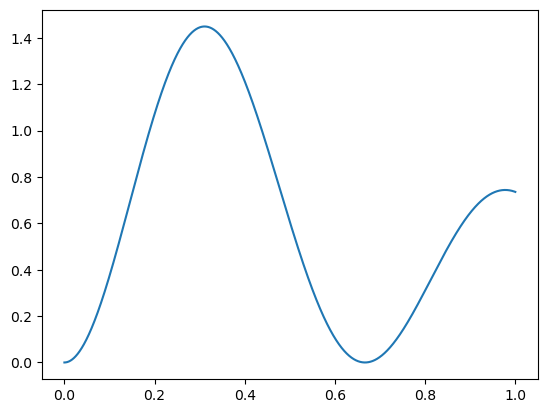

In [60]:
Nx = 1000
Nt = 20
param ={'Nx': Nx, 'Nt' : Nt}
x = np.linspace(0, 1, Nx)
D = Diffusion(Nx, 0.9, 1, 0.2e-2, model=model)
x0 = 2*np.exp(-x)*np.sin(3*np.pi/2*x)**2
x0 = x0.reshape(-1, 1)
bd1 = x0[0]
bd2 = x0[-1]

plt.plot(x, x0)
plt.show()

In [61]:
prob = one_phase(D, param)
solver_n = fxbd_1D(param, prob)
solver_n.setBoundary(bd1, bd2)
solver_n.setSources([0.625], [-0.6])

In [62]:
nl_solver = newton(crit_abs=1e-10)
solver_n.setSolver(nl_solver)

In [63]:
solver_n.setInitial(x0)
X, mes, t, delta = test(solver_n, sample_size = 4)

test started


KeyboardInterrupt: 

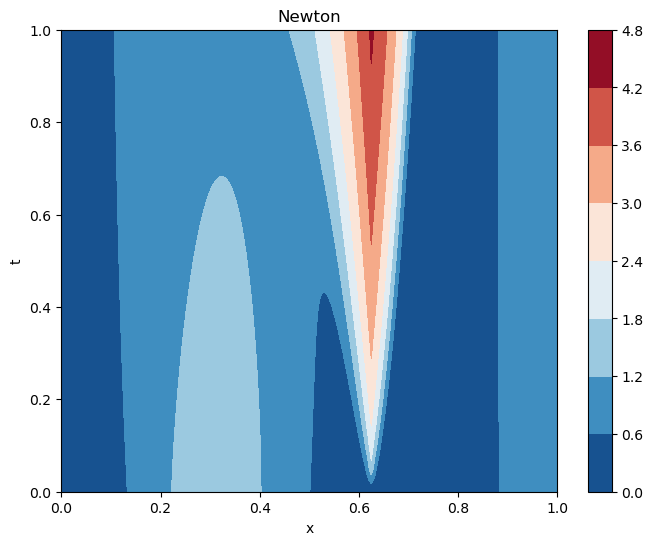

In [8]:
wp.show_res(solver_n)
plt.show()

In [9]:
prob = one_phase(D, param)
solver = fxbd_1D(param, prob)
solver.setBoundary(bd1, bd2)
solver.setSources([0.625], [-0.6])
solver.setInitial(x0)

In [10]:
Nd = 4
partion = pt.partion_equally(Nx, Nd)
nl_solver = aspen(Nd, partion, crit_abs=1e-10)
solver.setSolver(nl_solver)

In [11]:
X, mes, t, delta = test(solver, sample_size=4)

test started
verdict : OK
time : 15.45 +- 0.2606
mean aspen iterations:  3.4


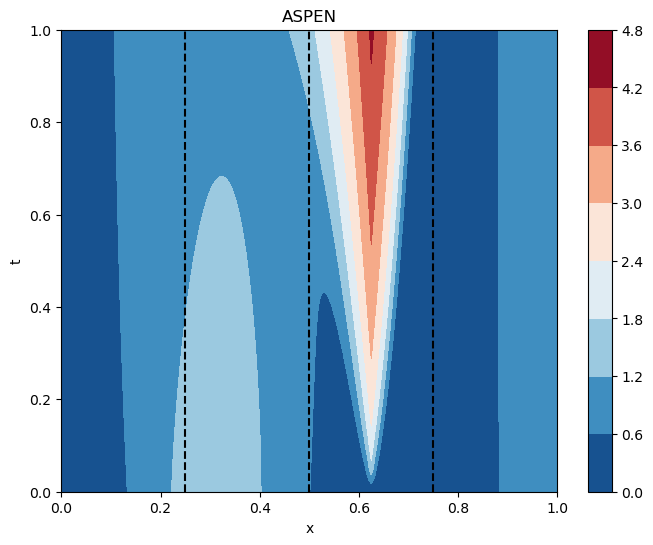

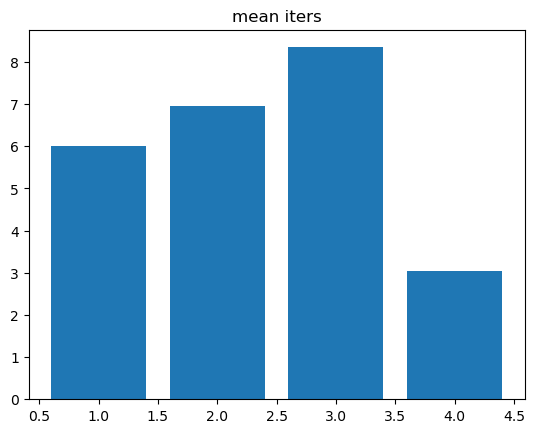

In [12]:
wp.show_res(solver, save='Diff0_ASPEN')
wp.bar_loc(solver, Nd, save='Diff0_mean_loc')

--time comparision--
newton : 6.662296533584595
aspen : 15.546012878417969


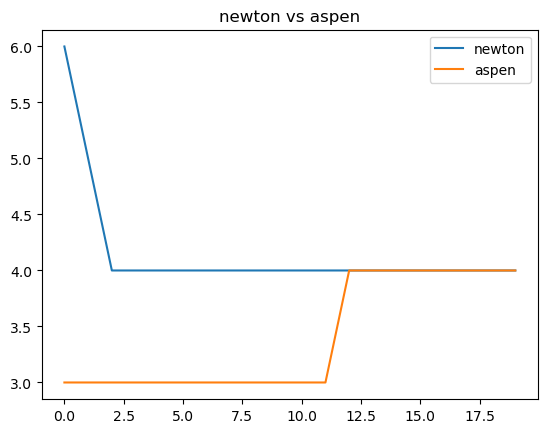

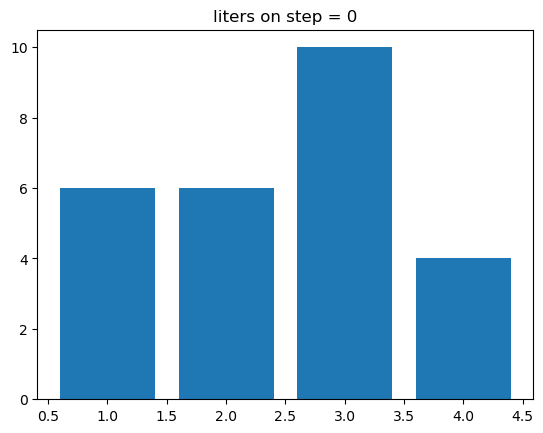

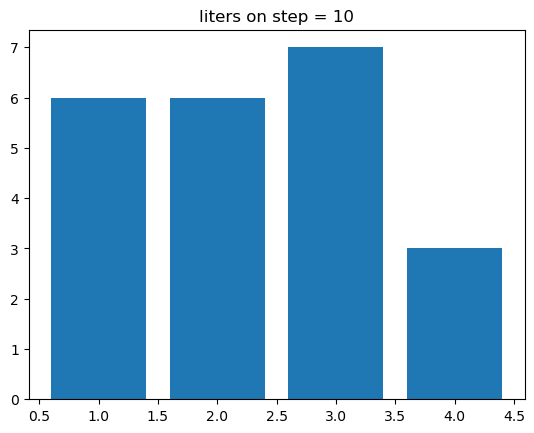

In [13]:
wp.compare([solver_n, solver], ['newton', 'aspen'], save='comp')
wp.bar_loc_step(solver, Nd, 0, save='step=0')
wp.bar_loc_step(solver, Nd, 10, save='step=10')

#### Исследуем зависимость от шага по времени

In [43]:
time = np.zeros((15, 2))
delta = np.zeros((15, 2))

Nx = 1000
Nd = 4

x = np.linspace(0, 1, Nx)
D = Diffusion(Nx, 0.9, 1, 0.2e-2, model=model)

nl_new = newton(crit_abs = 1e-10)
partion = pt.partion_equally(Nx, Nd)
nl_asp = aspen(Nd, partion, crit_abs=1e-10) 

for i in range(15):
    Nt = 4+2*(i)
    param ={'Nx': Nx, 'Nt' : Nt}
    prob = one_phase(D, param)
    solver = fxbd_1D(param, prob)
    solver.setBoundary(bd1, bd2)
    solver.setSources([0.625], [-0.6])
    solver.setInitial(x0)
    
    solver.setSolver(nl_new)
    _, mes, time[i, 0], delta[i, 0] = test(solver, sample_size=4)
    if(mes != 'OK'):
        print(mes, i) 
        
    prob = one_phase(D, param)
    solver = fxbd_1D(param, prob)
    solver.setBoundary(bd1, bd2)
    solver.setSources([0.625], [-0.6])
    solver.setInitial(x0)
    solver.setSolver(nl_asp)
    _, mes, time[i, 1], delta[i, 1] = test(solver, sample_size=4)
    if(mes != 'OK'):
        print(mes, i) 


test started
verdict : OK
time : 1.802 +- 0.1844
mean newton iterations:  5.5
test started
verdict : OK
time : 4.05 +- 0.3438
mean aspen iterations:  4.75
test started
verdict : OK
time : 2.868 +- 0.3894
mean newton iterations:  4.833333333333333
test started
verdict : OK
time : 6.093 +- 0.3948
mean aspen iterations:  4.5
test started
verdict : OK
time : 3.2 +- 0.1851
mean newton iterations:  4.5
test started
verdict : OK
time : 7.441 +- 0.214
mean aspen iterations:  4.25
test started
verdict : OK
time : 3.913 +- 0.1393
mean newton iterations:  4.4
test started
verdict : OK
time : 9.074 +- 0.6054
mean aspen iterations:  4.0
test started
verdict : OK
time : 4.607 +- 0.1496
mean newton iterations:  4.333333333333333
test started
verdict : OK
time : 10.09 +- 0.288
mean aspen iterations:  3.75
test started
verdict : OK
time : 5.476 +- 0.1945
mean newton iterations:  4.285714285714286
test started
verdict : OK
time : 11.01 +- 0.3293
mean aspen iterations:  3.4285714285714284
test started
ve

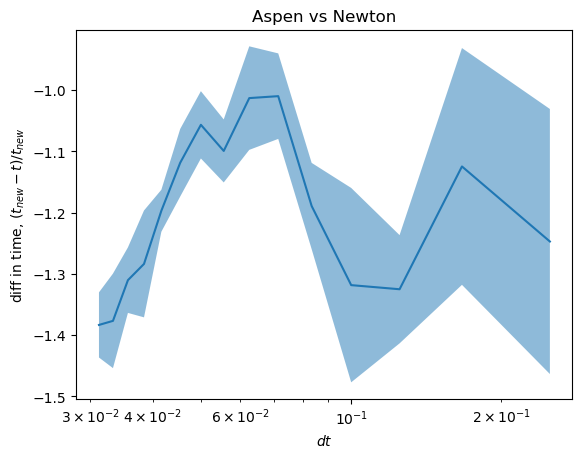

In [44]:
dif = 1 - time[:, 1]/time[:, 0]
dt = 1/(4+2*np.arange(0, 15))

plt.title('Aspen vs Newton')
plt.xlabel('$dt$')
plt.ylabel('diff in time, $(t_{new}-t) /t_{new}$')
plt.xscale('log')
plt.plot(dt, dif)
plt.fill_between(dt, dif+np.sqrt(delta[:, 0]**2+delta[:, 1]**2)/time[:, 0],
                dif-np.sqrt(delta[:, 0]**2+delta[:, 1]**2)/time[:, 0], alpha=0.5)
plt.savefig('./data/Diff0_dt_dep', dpi = 300)
plt.show()

### Иследуем Inexact подход к локальной стадии
Берем ту же проблему, но теперь локальные подсистемы решаем с разной точностью

In [45]:
Nd = 4
Nx = 1000
Nt = 20
param ={'Nx': Nx, 'Nt' : Nt}
x = np.linspace(0, 1, Nx)
param ={'Nx': Nx, 'Nt' : Nt}
D = Diffusion(Nx, 0.9, 1, 0.2e-2, model=model)

prob = one_phase(D, param)
solver = fxbd_1D(param, prob)
solver.setBoundary(bd1, bd2)
solver.setSources([0.625], [-0.6])
solver.setInitial(x0)

In [46]:
partion = pt.partion_equally(Nx, Nd)
nl_solver = aspen(Nd, partion, crit_abs = 1e-10)
solver.setSolver(nl_solver)

In [47]:
time = np.zeros(17)
delta = np.zeros(17)
gb_iters = np.zeros((17, Nt))
lc_iters = np.zeros((17, Nd, Nt))

i = 0
for crit_rel in np.logspace(-16, -0.05, 17):
    nl_solver = aspen(Nd, partion, newton_crit_rel = crit_rel)
    solver.setSolver(nl_solver)
    _, mes, time[i], delta[i] = test(solver, sample_size=4)
    gb_iters[i, :] = solver.timelog.aspen_iters
    lc_iters[i, :, :] = solver.timelog.domain_iters
    if(mes != 'OK'):
        print(i, mes)
    i += 1

test started
verdict : OK
time : 9.856 +- 0.1841
mean aspen iterations:  2.4
test started
verdict : OK
time : 10.39 +- 0.6232
mean aspen iterations:  2.4
test started
verdict : OK
time : 10.03 +- 0.736
mean aspen iterations:  2.4
test started
verdict : OK
time : 9.837 +- 0.175
mean aspen iterations:  2.4
test started
verdict : OK
time : 9.75 +- 0.07699
mean aspen iterations:  2.4
test started
verdict : OK
time : 9.865 +- 0.3795
mean aspen iterations:  2.4
test started
verdict : OK
time : 9.838 +- 0.5287
mean aspen iterations:  2.4
test started
verdict : OK
time : 10.21 +- 0.7853
mean aspen iterations:  2.4
test started
verdict : OK
time : 9.84 +- 0.385
mean aspen iterations:  2.4
test started
verdict : OK
time : 9.84 +- 0.2226
mean aspen iterations:  2.4
test started
verdict : OK
time : 9.813 +- 0.3468
mean aspen iterations:  2.4
test started
verdict : OK
time : 9.699 +- 0.2004
mean aspen iterations:  2.4
test started
verdict : OK
time : 9.719 +- 0.2764
mean aspen iterations:  2.4
test

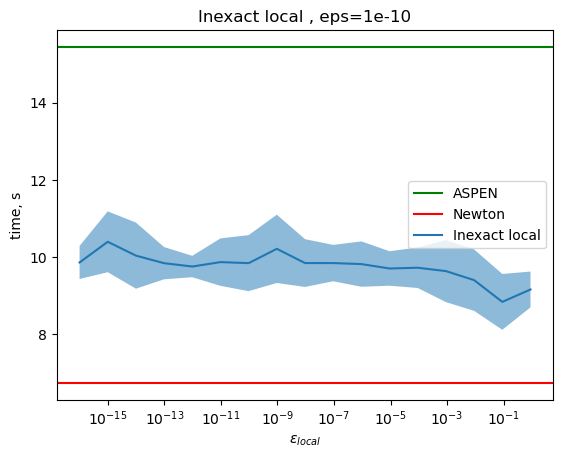

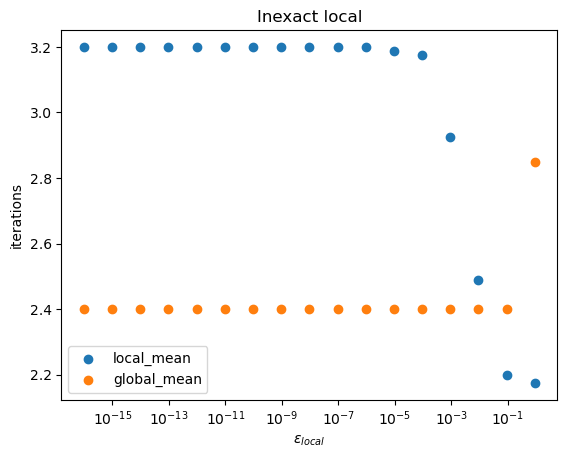

In [48]:
crit_rel = np.logspace(-16, -0.05, 17)

plt.title('Inexact local , eps=1e-10')
plt.ylabel('time, s')
plt.xlabel(r'$\varepsilon_{local}$')
plt.xscale('log')
plt.axhline(15.45, color='g', label='ASPEN')
plt.axhline(6.729, color='r', label='Newton')
plt.plot(crit_rel, time, label='Inexact local')
plt.fill_between(crit_rel, time+np.sqrt(delta),
                time-np.sqrt(delta), alpha=0.5)
plt.savefig('./data/Diff0_I_time', dpi=400)
plt.legend()
plt.show()

plt.title('Inexact local')
plt.ylabel('iterations')
plt.xlabel(r'$\varepsilon_{local}$')
plt.xscale('log')
plt.scatter(crit_rel, np.mean(np.mean(lc_iters, axis = 2), axis = 1), label='local')
plt.scatter(crit_rel, np.mean(gb_iters, axis = 1), label='global_mean')
plt.legend()
plt.savefig('./data/Diff0_I_lc_iters', dpi=400)
plt.show()

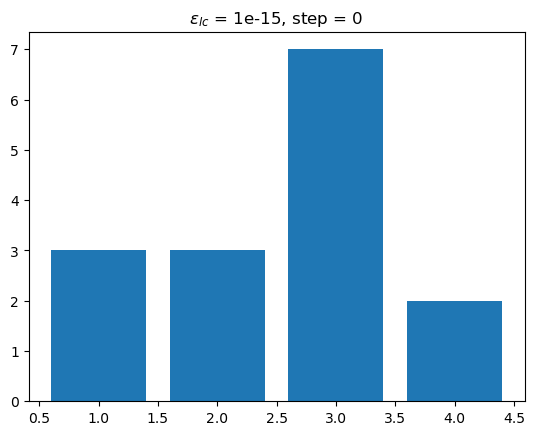

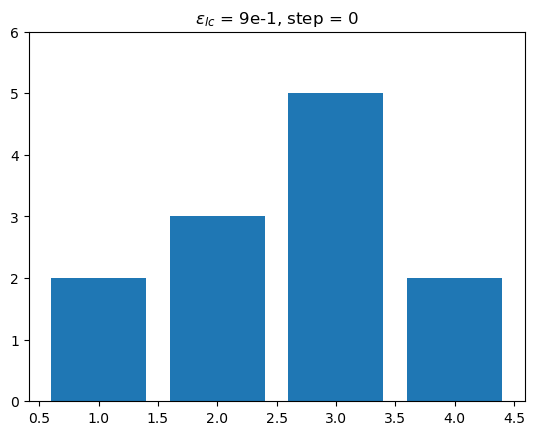

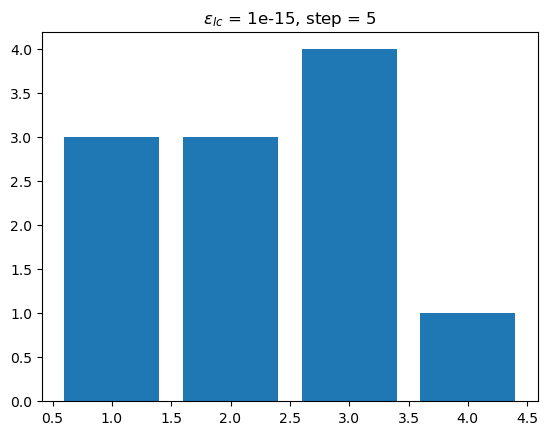

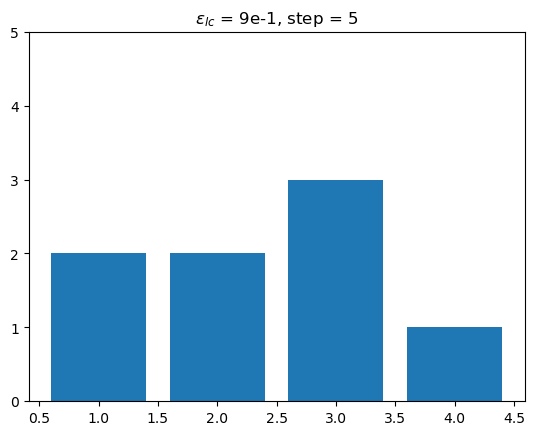

In [49]:
plt.title(r'$\varepsilon_{lc}$ = 1e-15, step = 0')
plt.bar(np.arange(1, 5), lc_iters[0, :, 0])
plt.savefig('ASpin1', dpi=400)
plt.show()
plt.title(r'$\varepsilon_{lc}$ = 9e-1, step = 0')
plt.ylim(0, 6)
plt.bar(np.arange(1, 5), lc_iters[-1, :, 0])
plt.savefig('ASpin2', dpi=400)
plt.show()

plt.title(r'$\varepsilon_{lc}$ = 1e-15, step = 5')
plt.bar(np.arange(1, 5), lc_iters[0, :, 5])
plt.savefig('ASpin3', dpi=400)
plt.show()
plt.title(r'$\varepsilon_{lc}$ = 9e-1, step = 5')
plt.ylim(0, 5)
plt.bar(np.arange(1, 5), lc_iters[-1, :, 5])
plt.savefig('ASpin4', dpi=400)
plt.show()

In [50]:
## Finally

In [54]:
prob = one_phase(D, param)
solver = fxbd_1D(param, prob)
solver.setBoundary(bd1, bd2)
solver.setSources([0.625], [-0.6])
solver.setInitial(x0)
Nd = 4
partion = pt.partion_equally(Nx, Nd)
nl_solver = aspen(Nd, partion, crit_abs=1e-10, newton_crit_rel = 0.5e-3)
solver.setSolver(nl_solver)

In [55]:
X, mes, t, delta = test(solver, sample_size=4)

test started
verdict : OK
time : 12.01 +- 0.8715
mean aspen iterations:  3.4


--time comparision--
newton : 6.662296533584595
aspen : 12.685790777206421


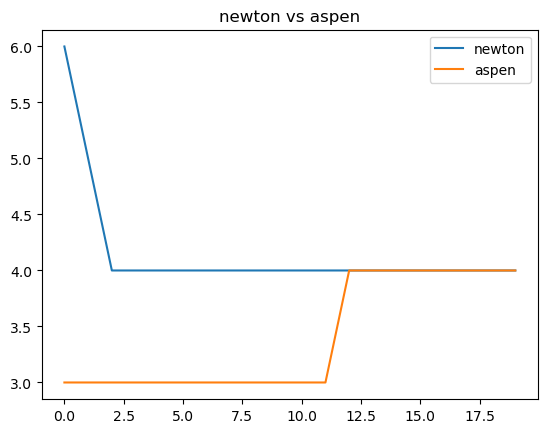

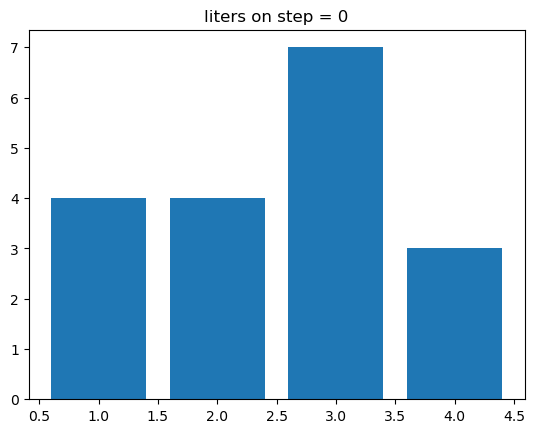

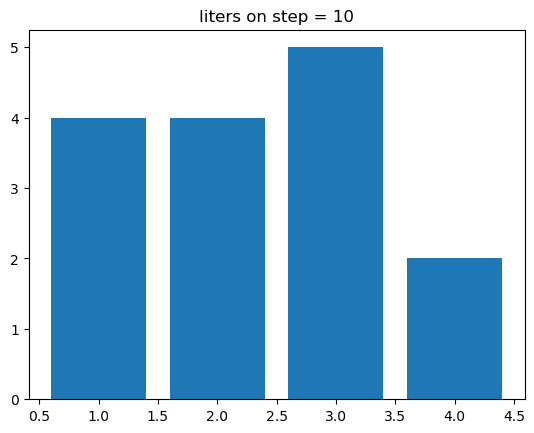

In [56]:
wp.compare([solver_n, solver], ['newton', 'aspen'], save='comp2')
wp.bar_loc_step(solver, Nd, 0, save='comp2_step=0')
wp.bar_loc_step(solver, Nd, 10, save='comp2_step=10')